## Importing some packages

In [66]:
import os.path
import numpy as np
import pandas as pd

from scipy.stats import ttest_ind, ttest_rel
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
from statsmodels.stats.contingency_tables import mcnemar

from config import *

## Loading the data

In [67]:
results_general = pd.read_csv(os.path.join(work_dir, 'results_general.csv'))
results_spherical = pd.read_csv(os.path.join(work_dir, 'results_spherical.csv'))

## Setting some global parameters

In [68]:
figsize= (7.5, 3.3)

## General distortions

### Plotting the figure of matching exact and simulated figures and AUC scores

relative variation for noisy window b
2                 3.1e-05
5                 7.3e-05
sturges-formula   3.0e-04
rice-rule         2.1e-04
square-root       4.1e-06
dtype: float64
relative variation for distorted template (general distortion) b
2                 2.9e-04
5                 1.0e-03
sturges-formula   1.4e-03
rice-rule         1.4e-03
square-root       1.1e-03
dtype: float64


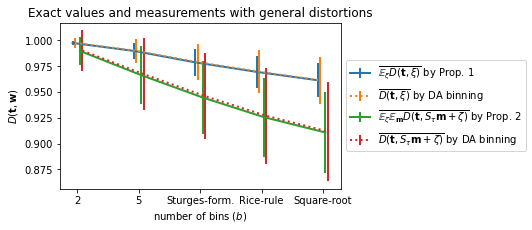

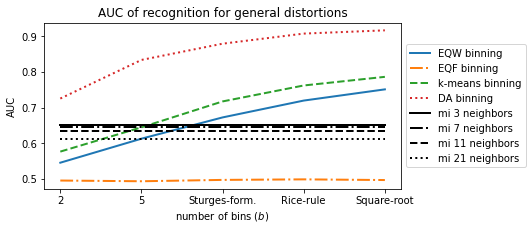

In [69]:
grouped= results_general.groupby(['b']).agg(['mean', 'std'])

grouped= grouped.loc[['2', '5', 'sturges-formula', 'rice-rule', 'square-root']]

print('relative variation for noisy window', abs(grouped[('exact_noise', 'mean')] - grouped[('distortion_aligned_noise', 'mean')])/grouped[('exact_noise', 'mean')])
print('relative variation for distorted template (general distortion)', abs(grouped[('exact_distortion', 'mean')] - grouped[('distortion_aligned_distorted', 'mean')])/grouped[('distortion_aligned_distorted', 'mean')])

fig, ax= plt.subplots(figsize=figsize)
trans0= Affine2D().translate(-0.08, 0.0) + ax.transData
trans1= Affine2D().translate(-0.04, 0.0) + ax.transData
trans2= Affine2D().translate(-0.0, 0.0) + ax.transData
trans3= Affine2D().translate(0.04, 0.0) + ax.transData
trans4= Affine2D().translate(0.08, 0.0) + ax.transData

ax.errorbar(np.arange(len(grouped)), grouped[('exact_noise', 'mean')], grouped[('exact_noise', 'std')], label='$\\overline{\\mathbb{E}_\\xi D(\\mathbf{t},\\xi)}$ by Prop. 1', linestyle='-', linewidth=2.0, transform=trans0)
ax.errorbar(np.arange(len(grouped)), grouped[('distortion_aligned_noise', 'mean')], grouped[('distortion_aligned_noise', 'std')], label='$\\overline{D(\\mathbf{t}, \\xi)}$ by DA binning', linewidth=2.0, linestyle=':', transform=trans1)
ax.errorbar(np.arange(len(grouped)), grouped[('exact_distortion', 'mean')], grouped[('exact_distortion', 'std')], label='$\\overline{\\mathbb{E}_\\zeta\\mathbb{E}_\\mathbf{m} D(\\mathbf{t}, S_\\tau \\mathbf{m} + \\zeta)}$ by Prop. 2', linestyle='solid', linewidth=2.0, transform=trans3)
ax.errorbar(np.arange(len(grouped)), grouped[('distortion_aligned_distorted', 'mean')], grouped[('distortion_aligned_distorted', 'std')], label='$\\overline{D(\\mathbf{t}, S_\\tau \\mathbf{m} + \\zeta)}$ by DA binning', linewidth=2.0, linestyle=':', transform=trans4)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_xlabel('number of bins ($b$)')
ax.set_ylabel('$D(\mathbf{t},\mathbf{w})$')
ax.set_title('Exact values and measurements with general distortions')
ax.set_xticks(np.arange(len(grouped)))
ax.set_xticklabels(['2', '5', 'Sturges-form.', 'Rice-rule', 'Square-root'])
plt.tight_layout()
plt.savefig('fit_general.pdf')

plt.figure(figsize=figsize)
plt.plot(np.arange(len(grouped)), grouped[('eqw_hits', 'mean')], label='EQW binning', linestyle='-', linewidth=2.0)
plt.plot(np.arange(len(grouped)), grouped[('eqf_hits', 'mean')], label='EQF binning', linewidth=2.0, linestyle='-.')
plt.plot(np.arange(len(grouped)), grouped[('kmeans_hits', 'mean')], label='k-means binning', linestyle='--', linewidth=2.0)
plt.plot(np.arange(len(grouped)), grouped[('distortion_aligned_hits', 'mean')], label='DA binning', linewidth=2.0, linestyle=':')
for i, n in enumerate(mi_n_neighbors):
    plt.plot(np.arange(len(grouped)), grouped[('mi_' + str(n) + '_hits', 'mean')], label='mi ' + str(n) + ' neighbors', linewidth=2.0, linestyle=['-', '-.', '--', ':'][i], c='black')

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('number of bins ($b$)')
plt.ylabel('AUC')
plt.title('AUC of recognition for general distortions')
plt.xticks(np.arange(len(grouped)), ['2', '5', 'Sturges-form.', 'Rice-rule', 'Square-root'])
plt.tight_layout()
plt.savefig('auc_general.pdf')

### Executing the statistical tests

In [70]:
means= np.array([np.mean(results_general['eqw_hits']), 
                 np.mean(results_general['eqf_hits']), 
                 np.mean(results_general['kmeans_hits']), 
                 np.mean(results_general['distortion_aligned_hits'])])

p_matrix_general= np.zeros(shape=(len(binning_methods), len(binning_methods)))

for i, b0 in enumerate(binning_methods):
    for j, b1 in enumerate(binning_methods):
        p_matrix_general[i][j]= ttest_rel(results_general[b0 + '_hits'], results_general[b1 + '_hits'])[1]

pd.options.display.float_format = '{:.1e}'.format
p= pd.DataFrame(np.vstack([p_matrix_general, means]), 
                columns= ['EQW', 'EQF', 'k-means', 'distortion_aligned'], 
                index=['EQW', 'EQF', 'k-means', 'distortion_aligned', 'accuracy']).fillna(1)

print("the matrix of p-values and mean AUCs for general distortions with paired t-test")
print(p.to_latex())


p_matrix_general= np.zeros(shape=(len(binning_methods), len(binning_methods)))

table= np.zeros(shape=(2,2))

for i, b0 in enumerate(binning_methods):
    for j, b1 in enumerate(binning_methods):
        a= results_general[b0 + '_hits'].values
        b= results_general[b1 + '_hits'].values

        for k in [0, 1]:
            for l in [0, 1]:
                table[k,l]= np.sum(np.logical_and(a == k, b == l))

        p_matrix_general[i][j]= mcnemar(table).pvalue

pd.options.display.float_format = '{:.1e}'.format
p= pd.DataFrame(np.vstack([p_matrix_general, means]), 
                columns= ['EQW', 'EQF', 'k-means', 'distortion_aligned'], 
                index=['EQW', 'EQF', 'k-means', 'distortion_aligned', 'accuracy']).fillna(1)

print("the matrix of p-values and mean AUCs for general distortions with mcnemar test")
print(p.to_latex())


the matrix of p-values and mean AUCs for general distortions with paired t-test
\begin{tabular}{lrrrr}
\toprule
{} &     EQW &     EQF &  k-means &  distortion\_aligned \\
\midrule
EQW                & 1.0e+00 & 0.0e+00 &  1.4e-59 &             0.0e+00 \\
EQF                & 0.0e+00 & 1.0e+00 &  0.0e+00 &             0.0e+00 \\
k-means            & 1.4e-59 & 0.0e+00 &  1.0e+00 &             0.0e+00 \\
distortion\_aligned & 0.0e+00 & 0.0e+00 &  0.0e+00 &             1.0e+00 \\
accuracy           & 6.6e-01 & 5.0e-01 &  7.0e-01 &             8.5e-01 \\
\bottomrule
\end{tabular}

the matrix of p-values and mean AUCs for general distortions with mcnemar test
\begin{tabular}{lrrrr}
\toprule
{} &     EQW &     EQF &  k-means &  distortion\_aligned \\
\midrule
EQW                & 1.0e+00 & 0.0e+00 &  1.4e-59 &             0.0e+00 \\
EQF                & 0.0e+00 & 1.0e+00 &  0.0e+00 &             0.0e+00 \\
k-means            & 1.4e-59 & 0.0e+00 &  1.0e+00 &             0.0e+00 \\
distortion\

## Spherical distortions

### Plotting the figure of matching exact and simulated figures and AUC scores

relative variation for noisy window b
2                 1.1e-05
5                 6.6e-05
sturges-formula   1.8e-04
rice-rule         3.7e-04
square-root       4.8e-04
dtype: float64
relative variation for distorted template (spherical distortion) b
2                 5.1e-03
5                 6.9e-05
sturges-formula   3.7e-05
rice-rule         1.5e-04
square-root       2.6e-04
dtype: float64


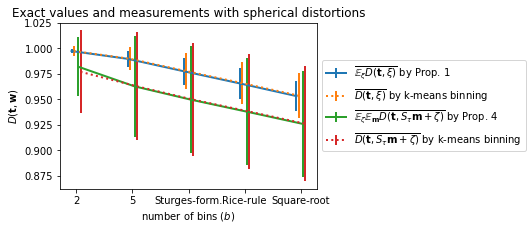

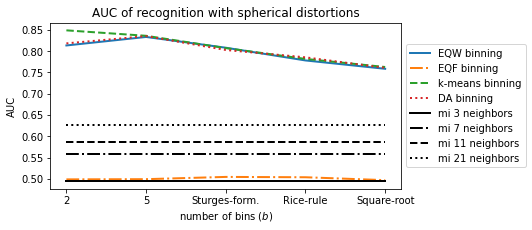

In [71]:
grouped= results_spherical.groupby(['b']).agg(['mean', 'std'])

grouped= grouped.loc[['2', '5', 'sturges-formula', 'rice-rule', 'square-root']]

print('relative variation for noisy window', abs(grouped[('exact_noise', 'mean')] - grouped[('kmeans_noise', 'mean')])/grouped[('exact_noise', 'mean')])
print('relative variation for distorted template (spherical distortion)', abs(grouped[('exact_kmeans', 'mean')] - grouped[('kmeans_distorted', 'mean')])/grouped[('exact_kmeans', 'mean')])

fig, ax= plt.subplots(figsize=figsize)
trans0= Affine2D().translate(-0.08, 0.0) + ax.transData
trans1= Affine2D().translate(-0.04, 0.0) + ax.transData
trans2= Affine2D().translate(-0.0, 0.0) + ax.transData
trans3= Affine2D().translate(0.04, 0.0) + ax.transData
trans4= Affine2D().translate(0.08, 0.0) + ax.transData
trans5= Affine2D().translate(0.12, 0.0) + ax.transData

ax.errorbar(np.arange(len(grouped)), grouped[('exact_noise', 'mean')], grouped[('exact_noise', 'std')], label='$\\overline{\\mathbb{E}_\\xi D(\\mathbf{t},\\xi)}$ by Prop. 1', linestyle='-', linewidth=2.0, transform=trans0)
ax.errorbar(np.arange(len(grouped)), grouped[('kmeans_noise', 'mean')], grouped[('kmeans_noise', 'std')], label='$\\overline{D(\\mathbf{t}, \\xi)}$ by k-means binning', linewidth=2.0, linestyle=':', transform=trans1)
ax.errorbar(np.arange(len(grouped)), grouped[('exact_kmeans', 'mean')], grouped[('exact_kmeans', 'std')], label='$\\overline{\\mathbb{E}_\\zeta\\mathbb{E}_\\mathbf{m} D(\\mathbf{t}, S_\\tau \\mathbf{m} + \\zeta)}$ by Prop. 4', linestyle='solid', linewidth=2.0, transform=trans3)
ax.errorbar(np.arange(len(grouped)), grouped[('kmeans_distorted', 'mean')], grouped[('kmeans_distorted', 'std')], label='$\\overline{D(\\mathbf{t}, S_\\tau \\mathbf{m} + \\zeta)}$ by k-means binning', linewidth=2.0, linestyle=':', transform=trans4)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_xlabel('number of bins ($b$)')
ax.set_ylabel('$D(\mathbf{t},\mathbf{w})$')
ax.set_title('Exact values and measurements with spherical distortions')
ax.set_xticks(np.arange(len(grouped)))
ax.set_xticklabels(['2', '5', 'Sturges-form.', 'Rice-rule', 'Square-root'])
plt.tight_layout()
plt.savefig('fit_spherical.pdf')

plt.figure(figsize=figsize)
plt.plot(np.arange(len(grouped)), grouped[('eqw_hits', 'mean')], label='EQW binning', linestyle='-', linewidth=2.0)
plt.plot(np.arange(len(grouped)), grouped[('eqf_hits', 'mean')], label='EQF binning', linewidth=2.0, linestyle='-.')
plt.plot(np.arange(len(grouped)), grouped[('kmeans_hits', 'mean')], label='k-means binning', linestyle='--', linewidth=2.0)
plt.plot(np.arange(len(grouped)), grouped[('distortion_aligned_hits', 'mean')], label='DA binning', linewidth=2.0, linestyle=':')
for i, n in enumerate(mi_n_neighbors):
    plt.plot(np.arange(len(grouped)), grouped[('mi_' + str(n) + '_hits', 'mean')], label='mi ' + str(n) + ' neighbors', linewidth=2.0, linestyle=['-', '-.', '--', ':'][i], c='black')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('number of bins ($b$)')
plt.ylabel('AUC')
plt.title('AUC of recognition with spherical distortions')
plt.xticks(np.arange(len(grouped)), ['2', '5', 'Sturges-form.', 'Rice-rule', 'Square-root'])
plt.tight_layout()
plt.savefig('auc_spherical.pdf')


### Executing the statistical tests

In [72]:
means= np.array([np.mean(results_spherical['eqw_hits']), 
                 np.mean(results_spherical['eqf_hits']), 
                 np.mean(results_spherical['kmeans_hits']), 
                 np.mean(results_spherical['distortion_aligned_hits'])])


p_matrix_spherical= np.zeros(shape=(len(binning_methods), len(binning_methods)))

for i, b0 in enumerate(binning_methods):
    for j, b1 in enumerate(binning_methods):
        p_matrix_spherical[i][j]= ttest_rel(results_spherical[b0 + '_hits'], results_spherical[b1 + '_hits'])[1]

pd.options.display.float_format = '{:.1e}'.format
p= pd.DataFrame(np.vstack([p_matrix_spherical, means]), 
                columns= ['EQW', 'EQF', 'k-means', 'distortion_aligned'], 
                index=['EQW', 'EQF', 'k-means', 'greedy', 'distortion_aligned']).fillna(1)

print("the matrix of p-values and mean AUCs for spherical distortions")
print(p.to_latex())

for i, b0 in enumerate(binning_methods):
    for j, b1 in enumerate(binning_methods):
        a= results_spherical[b0 + '_hits'].values
        b= results_spherical[b1 + '_hits'].values

        for k in [0, 1]:
            for l in [0, 1]:
                table[k,l]= np.sum(np.logical_and(a == k, b == l))

        p_matrix_spherical[i][j]= mcnemar(table).pvalue

pd.options.display.float_format = '{:.1e}'.format
p= pd.DataFrame(np.vstack([p_matrix_spherical, means]), 
                columns= ['EQW', 'EQF', 'k-means', 'distortion aligned'], 
                index=['EQW', 'EQF', 'k-means', 'greedy', 'distortion aligned']).fillna(1)

print("the matrix of p-values and mean AUCs for spherical distortions with mcnemar test")
print(p.to_latex())

the matrix of p-values and mean AUCs for spherical distortions
\begin{tabular}{lrrrr}
\toprule
{} &     EQW &     EQF &  k-means &  distortion\_aligned \\
\midrule
EQW                & 1.0e+00 & 0.0e+00 &  3.9e-07 &             2.3e-01 \\
EQF                & 0.0e+00 & 1.0e+00 &  0.0e+00 &             0.0e+00 \\
k-means            & 3.9e-07 & 0.0e+00 &  1.0e+00 &             5.5e-08 \\
greedy             & 2.3e-01 & 0.0e+00 &  5.5e-08 &             1.0e+00 \\
distortion\_aligned & 8.0e-01 & 5.0e-01 &  8.1e-01 &             8.0e-01 \\
\bottomrule
\end{tabular}

the matrix of p-values and mean AUCs for spherical distortions with mcnemar test
\begin{tabular}{lrrrr}
\toprule
{} &     EQW &     EQF &  k-means &  distortion aligned \\
\midrule
EQW                & 1.0e+00 & 0.0e+00 &  4.1e-07 &             2.4e-01 \\
EQF                & 0.0e+00 & 1.0e+00 &  0.0e+00 &             0.0e+00 \\
k-means            & 4.1e-07 & 0.0e+00 &  1.0e+00 &             5.9e-08 \\
greedy             & 2.4e-0

## Runtimes

In [73]:
np.mean(results_general[[c for c in results_general.columns if c.endswith('runtime')]])

eqw_runtime                  1.4e-03
eqf_runtime                  1.4e-03
kmeans_runtime               4.8e-03
distortion_aligned_runtime   9.4e-02
mi_3_runtime                 2.9e-02
mi_7_runtime                 3.1e-02
mi_11_runtime                3.0e-02
mi_21_runtime                2.5e-02
mi_31_runtime                2.2e-02
mi_41_runtime                2.1e-02
dtype: float64

In [74]:
np.mean(results_spherical[[c for c in results_general.columns if c.endswith('runtime')]])

eqw_runtime                  1.6e-03
eqf_runtime                  1.5e-03
kmeans_runtime               5.7e-03
distortion_aligned_runtime   1.9e-01
mi_3_runtime                 3.0e-02
mi_7_runtime                 3.1e-02
mi_11_runtime                3.0e-02
mi_21_runtime                2.5e-02
mi_31_runtime                2.2e-02
mi_41_runtime                2.1e-02
dtype: float64